# LAMMPS Tutorials 07. Per Atom Metrics!

### Author: Mark Tschopp, mark.a.tschopp.civ at mail.mil

Please contact me if you have a problem with this tutorial, so I can modify in Github.  I have added FAQs, and will update my versions of LAMMPS in the future to keep the scripts current.

The latest version of this [Jupyter Notebook](http://ipython.org/notebook.html) tutorial is available at https://github.com/mrkllntschpp/lammps-tutorials.

The original tutorials are given here: https://icme.hpc.msstate.edu/mediawiki/index.php/LAMMPS_tutorials.  A number of these tutorials are out of date and have been ported over into the current iPython Jupyter Notebook tutorials on github.

***
## Abstract:
<a id="Sec1"></a>

This example shows how to run an atomistic simulation of fracture of an iron symmetric tilt grain boundary. A parallel molecular dynamics code, LAMMPS [1], is used to calculate stresses at the grain boundary as the strain of the bicrystal is incrementally increased. Matlab is used to plot a stress-strain curve, and AtomEye [2] is used to visualize the simulation. 

***
## Complete the First Tutorials

If you have not done so already, you may want to complete the first tutorials available [here](https://github.com/mrkllntschpp/lammps-tutorials). 

## Step 1: Download Potential and Grain Boundary 

Similar to the last tutorial, this tutorial will need a potential and a grain boundary file.  To make it easy, I used the same as the last tutorial.

The interatomic potential needed for this is the Hepburn and Ackland (2008) Fe-C potential.  Download it at the [NIST Interatomic Potential Repository](https://www.ctcms.nist.gov/potentials/) in the `Fe` path, under the `C-Fe` subheading, i.e., the [2008--Hepburn-D-J-Ackland-G-J--Fe-C](https://www.ctcms.nist.gov/potentials/entry/2008--Hepburn-D-J-Ackland-G-J--Fe-C/).  This particular potential was chosen because it was used to create the grain boundary for studies of segregation of C atoms to various positions of various grain boundaries, even though the C part of the potential was not used within this example.

The grain boundary structure that was generated prior to this example can be found [here](https://icme.hpc.msstate.edu/mediawiki/index.php/Fe_110_sig3.txt). Store the text in "Fe_110_sig3.txt" to use it.

In this tutorial, I stored the LAMMPS commands for the potential in a separate text file `potential_FeC.txt`.  If you fed in a variable with the potential filename, it can be called within the LAMMPS script using an `include` command.  This shows how easy it is to just change the interatomic potential from the command line for inclusion in a loop structure! 

In [1]:
%%writefile potential_FeC.txt

##############################
# INTERATOMIC POTENTIAL FILE
pair_style eam/fs
pair_coeff * * Fe-C_Hepburn_Ackland.eam.fs Fe C


Overwriting potential_FeC.txt


## Step 2: Create the LAMMPS input script 

This input script was run using the January 2020 version of LAMMPS. Changes in some commands in more recent versions may require revision of the input script. This script runs the simulation with the previously generated grain boundary file, which is fed to LAMMPS through the `read_data` command.  To run this script, store it in `in.gb_metrics.txt`and use 

`lmp_exe < in.gb_metrics.txt` 

in a UNIX environment where `lmp_exe` refers to the LAMMPS executable. 

This script has a number of variables coded in, but these can easily be commented out, inserted through the command line, and cycled through in a loop.  In general, here is what this does:
* Load the Grain Boundary datafile
* Define the Interatomic Potential
* Define a number of different computes for per-atom properties
* Run a short minimization routine with dump file that includes computes (necessary for initializing these!)
* Loop over all atoms, printing per-atom metrics in the log file along with a flag (important for when we mine the per-atom metrics from the log file)
* Delete the dump file

In [2]:
%%writefile in.gb_metrics.txt
# LAMMPS Input File for Grain Boundaries 
# Mark Tschopp
# This file will generate numerous input files for LAMMPS 
# using a large number of grain boundaries 
# syntax: lmp_exe -in in.gb_metrics.txt
# or draw in variables from command line, e.g., 
# syntax: lmp_exe -var fname gb_metrics -var datfile Fe_110_sig3 -in in.gb_metrics.txt

# ---------- Setup Variables --------------------- 
variable etol equal 1.0e-10
variable ftol equal 1.0e-10 
variable maxiter equal 5000 
variable maxeval equal 10000 
variable cutoff equal 3.5 
variable datfile string "Fe_110_sig3"
variable fname string "gb_metrics"
variable potname string "potential_FeC.txt"

log log.${fname}.txt

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
atom_modify map array

######################################
# SIMULATION CELL VARIABLES (in Angstroms)

# DATA FILE
read_data ${datfile}.txt

# DUMP FILE:
# region box1 prism 0 1 0 1 0 1 0 0 0
# create_box 5 box1
# read_dump ${fname} 0 x y z add yes

replicate 1 1 1

# ---------- Define Interatomic Potential --------------------- 
include ${potname}

# ---------- Define Computes --------------------- 
compute 1 all pe/atom 
compute 2 all property/atom fx fy fz
# or bcc/14 for snn
# or fcc/18 for snn
compute 3 all centro/atom bcc
compute 3a all centro/atom 14
#compute 3b all centro/atom fcc
#compute 3c all centro/atom 18
compute 4 all cna/atom ${cutoff}
compute 5 all coord/atom cutoff ${cutoff}
compute 6 all stress/atom NULL
# compute 7 all voronoi/atom

# UNUSED per-atom computes (but could be used)
#compute 8 all ackland/atom
#compute 9 all cnp/atom 3.5

# 0.8535 * latconst (fcc), 1.207 * latconst (bcc), hcp... much more complicated.  0.25 is sigma
#compute 10 all entropy/atom 0.25 3.5

# entropy for fcc Al (4.05 to 5.7) above.  3 components of unit vector
#compute 11 all basal/atom

# functions.  require more outputs - 5 of them?
#compute 12 all orientorder/atom degrees 5 4 6 8 10 12 nnn 8 cutoff 3.5

# Not built with Windows executable (doh! oh snap...):
# compute 13 all ptm/atom fcc-hcp-bcc-ico 0.15 all
# compute 14 all snap/atom 1.4 0.95 6 2.0 1.0

dump 1 all custom 10000 dump.${fname}.* id c_1 c_2[1] c_3 c_3a c_4 c_5 & 
                                           c_6[1] # c_7[1] &
                                           # c_3b c_3c c_8 c_9 c_10 c_11 c_12

# ---------- Run Minimization --------------------- 
reset_timestep 0 
thermo 10 
thermo_style custom step pe press
min_style cg 
minimize ${etol} ${ftol} ${maxiter} ${maxeval} 

# ---------- MATLAB Interface Data --------------------- 

variable natoms equal "count(all)" 
variable perx equal lx
variable pery equal ly
variable perz equal lz

label loopi
variable i loop ${natoms}
variable xd equal x[$i]
variable yd equal y[$i]
variable zd equal z[$i]
variable p1 equal c_1[$i]
variable p2 equal c_2[$i][1]
variable p3 equal c_2[$i][2]
variable p4 equal c_2[$i][3]
variable p5 equal c_3[$i]
variable p6 equal c_3a[$i]
variable p7 equal c_4[$i]
variable p8 equal c_5[$i]
variable p9 equal c_6[$i][1]
variable p10 equal c_6[$i][2]
variable p11 equal c_6[$i][3]
variable p12 equal c_6[$i][4]
variable p13 equal c_6[$i][5]
variable p14 equal c_6[$i][6]
# variable p15 equal c_7[$i][1]
# variable p16 equal c_7[$i][2]

# FOR MATLAB
# This is just an example of how you could draw each individual value into a separate array
# ...or just modify the below (Python) print to bring into a large array in MATLAB
# Beware the triple quotes!  Even if you comment them out, they persist...
#print """
#%%xd($i) = ${xd}; yd($i) = ${yd}; zd($i) = ${zd};
#%%p_pe($i) = ${p1}; p_f($i,1) = ${p2}; p_f($i,2) = ${p3}; p_f($i,3) = ${p4};
#%%p_centro_fnn($i) = ${p5}; p_centro_snn($i) = ${p6}; p_cna($i) = ${p7}; p_coord($i) = ${p8};
#%%p_stress($i,1) = ${p9};p_stress($i,2) = ${p10};p_stress($i,3) = ${p11};
#%%p_stress($i,4) = ${p12};p_stress($i,5) = ${p13};p_stress($i,6) = ${p14};
#%%p_voronoi($i,1) = ${p15};p_voronoi($i,2) = ${p16};
#"""

# FOR PYTHON
# Define a list, i.e., data = []
# run through each line, flagging the %% (ignores the ones with "print" in them)
# exec(line.replace("%%","data.append(")+")")    (print)
# ... OR FOR MATLAB
# just draw this straight into an array
# exec([replace(line,"%%","data=[data,"),"];"])  (print)
print "%%[$i,${xd},${yd},${zd},${p1},${p2},${p3},${p4},${p5},${p6},${p7},${p8},${p9},${p10},${p11},${p12},${p13},${p14}]" # ,${p15},${p16}]"

next i
jump in.${fname}.txt loopi
variable i delete

# FOR MATLAB uncomment
# print "%%natoms = ${natoms};perx = ${perx};pery = ${pery};perz = ${perz};"

# FOR PYTHON uncomment
print "%%natoms,perx,pery,perz = ${natoms},${perx},${pery},${perz}"

shell rm dump.${fname}.0

######################################
# SIMULATION DONE
print "All done"

Overwriting in.gb_metrics.txt


## Step 3: Run the LAMMPS Simulation

Now run the simulation as we have done before using the syntax 

`lmp_exe < in.gb_metrics.txt`.  

On my computer, the 24Jan2020 LAMMPS executable is stored in the `C:\Program Files\LAMMPS 64-bit 24Jan2020\bin\` folder and is named `lmp_serial.exe`.  

The `log.gb_metrics.txt` file should look like the output below. The simulation took a few seconds on my computer.

In [3]:
import time
start_time = time.time()
!lmp_serial < in.gb_metrics.txt
print("--- %s seconds ---" % (time.time() - start_time))

LAMMPS (3 Mar 2020)
Reading data file ...
  orthogonal box = (0 -123.994 0) to (6.99406 123.994 4.03802)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  600 atoms
  read_data CPU = 0.00182295 secs
Replicating atoms ...
  orthogonal box = (0 -123.994 0) to (6.99406 123.994 4.03802)
  1 by 1 by 1 MPI processor grid
  600 atoms
  replicate CPU = 0.000776052 secs
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.3
  ghost atom cutoff = 7.3
  binsize = 3.65, bins = 2 68 2
  5 neighbor lists, perpetual/occasional/extra = 1 4 0
  (1) pair eam/fs, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
  (2) compute centro/atom, occasional
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
  (3) compute centro/atom, occasional
      attri

***
## Step 4: Post-Processing the Simulation 

So, now what?  In a similar way to [Tutorial 2](LAMMPS-Tutorials-02.ipynb), you can use the MATLAB script to mine the data from the log file, or you can do it in Python within this Jupyter Notebook.

### Extract per-atom metrics using Python:

In [4]:
import glob, os
import time

start_time = time.time()
target = "%%"
data = []
for file in glob.glob("log.gb_metrics.txt"):
    with open(file) as f:
        for line in f:
            if target in line and "print" not in line and "$" not in line:
                if "[" in line:
#                    print(line.replace("%%","data.append(")+")")
                    exec(line.replace("%%","data.append(")+")")
                else:
#                    print(line.replace("%%",""))
                    exec(line.replace("%%",""))

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.040086984634399414 seconds ---


Just to test it, did it automatically extract the variables at the very end of the script? That is, natoms, perx, pery, perz (number of atoms, periodic distances of the simulation cell in x/y/z, respectively).

In [5]:
# Just a test
print("natoms:", natoms)
print("perx:",perx)
print("pery:",pery)
print("perz:",perz)

natoms: 600
perx: 6.99406
pery: 247.988006
perz: 4.03802


OK. So now let's tackle the huge amount of data. When the above script mined the log file line-by-line, it stored the data for each atom within a list variable `data` using the `data.append` Python command.  It turns out that this is much faster than storing it directly into an array, but it is easy to convert using numpy!  

In [6]:
# Fastest to import data to list, but now convert it to an array using numpy
import numpy as np
data1 = np.asarray(data)
print("Data_xyz:",data1[:,1:4])
print("Data shape:",data1.shape)

Data_xyz: [[ 5.47909335e+00 -1.10215325e+02  2.01901000e+00]
 [ 5.47891999e+00 -1.15162767e+02  2.01901000e+00]
 [ 4.31330268e+00 -1.13511171e+02  1.97298028e-16]
 ...
 [ 3.14698033e+00  1.20946365e+02  2.01901000e+00]
 [ 3.14715263e+00  1.23580670e+02  2.01901000e+00]
 [ 4.31269820e+00  1.22422582e+02 -8.51244966e-17]]
Data shape: (600, 18)


## Step 5: Visualization

OK. So now that we have the data, we can use it for any number of things.  Like just plotting the atomic coordinates, colored by the in-plane coordinate (z-direction).  I'll use the 'hot' colormap to give the classic black and white grain boundary structure look for atoms that sit on different $\{110\}$ planes.  I added a second set of atoms in the x-direction to extend the simulation cell (replicate atoms because of the periodic boundary) and only chose those atoms within 5 Angstroms of the grain boundary. 

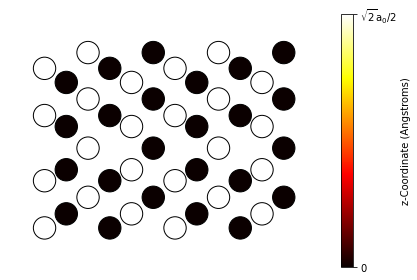

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# or look through the dictionary, plt.cm.__dict__
cmap = plt.cm.get_cmap('hot')

fig, ax = plt.subplots()
n = np.abs(data1[:,2]) < 5
cax1 = ax.scatter(data1[n,1], data1[n,2],c=data1[n,3],ec = 'k',s=500,alpha=1,cmap=cmap)
cax = ax.scatter(data1[n,1]+perx, data1[n,2],c=data1[n,3],ec = 'k',s=500,alpha=1,cmap=cmap)
ax.set_aspect('equal')
ax.set_ylim(data1[n,2].min()-2,data1[n,2].max()+2)
ax.set_xlim(data1[:,1].min()-2,data1[:,1].max()+perx+2)
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0, 2.019], orientation='vertical')
cbar.ax.set_yticklabels(['0', '$\sqrt{2}$a$_0$/2']) # horizontal colorbar
cbar.set_label('z-Coordinate (Angstroms)', rotation=90)
fig.tight_layout()
plt.show()

So how did I choose `2.019` for the tick mark on the colorbar? Simple. I looked at the minimum and maximum z-coordinates for the dataset (it was nice because even the grain boundary atoms stayed in the $\{110\}$ planes).  Knowing that it is a BCC crystal structure in the $<110> direction$, there is a $\sqrt(2)/2$ spacing between $\{110\}$ planes.  So, the lattice constant for this interatomic potential must be: 

In [8]:
print("Lattice Constant, a0:", 2*(data1[:,3].max()-data1[:,3].min())/np.sqrt(2), "Angstroms")


Lattice Constant, a0: 2.8553113245669057 Angstroms


I guess you could color it by another colormap, too.  Let's look in the matplotlib colormap dictionary `plt.cm.__dict__`.  Hmm, it looks like there is a variable `datad` (for data dictionary?).

In [9]:
plt.cm.__dict__ # what's in the dictionary?
plt.cm.datad # data dictionary for colormaps?

{'Blues': ((0.9686274509803922, 0.984313725490196, 1.0),
  (0.8705882352941177, 0.9215686274509803, 0.9686274509803922),
  (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
  (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
  (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
  (0.25882352941176473, 0.5725490196078431, 0.7764705882352941),
  (0.12941176470588237, 0.44313725490196076, 0.7098039215686275),
  (0.03137254901960784, 0.3176470588235294, 0.611764705882353),
  (0.03137254901960784, 0.18823529411764706, 0.4196078431372549)),
 'BrBG': ((0.32941176470588235, 0.18823529411764706, 0.0196078431372549),
  (0.5490196078431373, 0.3176470588235294, 0.0392156862745098),
  (0.7490196078431373, 0.5058823529411764, 0.17647058823529413),
  (0.8745098039215686, 0.7607843137254902, 0.49019607843137253),
  (0.9647058823529412, 0.9098039215686274, 0.7647058823529411),
  (0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
  (0.7803921568627451, 0.91764

So, I'm going to the 'BuGr' colormap and color it by the potential energy (`data1[:,4]`).

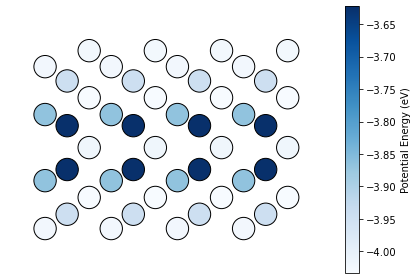

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# or look through the dictionary, plt.cm.__dict__
cmap = plt.cm.get_cmap('Blues')

fig, ax = plt.subplots()
n = np.abs(data1[:,2]) < 5
cax = ax.scatter(data1[n,1], data1[n,2],c=data1[n,4],ec = 'k',s=500,alpha=1,cmap=cmap)
cax = ax.scatter(data1[n,1]+perx, data1[n,2],c=data1[n,4],ec = 'k',s=500,alpha=1,cmap=cmap)
ax.set_aspect('equal')
ax.set_ylim(data1[n,2].min()-2,data1[n,2].max()+2)
ax.set_xlim(data1[:,1].min()-2,data1[:,1].max()+perx+2)
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Potential Energy (eV)',rotation=90)
fig.tight_layout()
plt.show()

***
## FAQs 

</br>
<div class="alert alert-danger">
    <strong>Question 1</strong>: None yet.  
</div>


***
## Links

* [Click here to open Tutorial 1](LAMMPS-Tutorials-01.ipynb)
* [Click here to open Tutorial 2](LAMMPS-Tutorials-02.ipynb)
* [Click here to open Tutorial 3](LAMMPS-Tutorials-03.ipynb)
* [Click here to open Tutorial 4](LAMMPS-Tutorials-04.ipynb)
* [Click here to open Tutorial 5](LAMMPS-Tutorials-05.ipynb)
* [Click here to open Tutorial 6](LAMMPS-Tutorials-06.ipynb)
* [Click here to open the next tutorial](LAMMPS-Tutorials-08.ipynb)

***
## References 

1. S. Plimpton, "Fast Parallel Algorithms for Short-Range Molecular Dynamics," J. Comp. Phys., 117, 1-19 (1995). 
1. D.J. Hepburn, and G.J. Ackland (2008), "[Metallic-covalent interatomic potential for carbon in iron](https://doi.org/10.1103/physrevb.78.165115)", Physical Review B, 78(16), 165115. 
1. MA Tschopp, F Gao, KN Solanki (2017) "[He–V cluster nucleation and growth in α-Fe grain boundaries](https://doi.org/10.1016/j.actamat.2016.11.027)", Acta Materialia 124, 544-555.
